In [7]:
import matplotlib
matplotlib.use('TkAgg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotData



In [2]:
def compute_p(k_matrix: np.matrix, t_matrix: np.matrix) -> np.matrix:
    """
    Compute the projection matrix.
    """
    t_matrix_inverted = np.linalg.inv(t_matrix)
    canon_matrix = np.matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0]])
    p_matrix = k_matrix @ canon_matrix @ t_matrix_inverted
    return p_matrix

def svd_triangulation(p1_matrix: np.matrix, p2_matrix: np.matrix, x1_data: np.matrix, x2_data: np.matrix) -> np.matrix:
    """Triangulates the 3D point from two 2D points and the projection matri using SVD."""
    # create an empty matrix: 4 rows, 0 columns
    x_3d = np.empty((4, 0))
    for i in range(x1_data.shape[1]):   # for each point
        point1 = np.append(x1_data[:, i], 1) # the point is now a 3D point
        point2 = np.append(x2_data[:, i], 1)
        # now we calculate the 3D position of the point using SVD
        ## calculate the equation system
        ec = np.empty([4, 4])
        # for each row of the equation system (equation on page 6 lecture 6)
        for j in range(4):
            ec[j, 0] = p1_matrix[2, j] * point1[0] - p1_matrix[0, j]
            ec[j, 1] = p1_matrix[2, j] * point1[1] - p1_matrix[1, j]
            ec[j, 2] = p2_matrix[2, j] * point2[0] - p2_matrix[0, j]
            ec[j, 3] = p2_matrix[2, j] * point2[1] - p2_matrix[1, j]
        ## obtain the 3d point using svd to solve the system
        u, s, vh = np.linalg.svd(ec.T)
        # the 3D point is the last column of vh
        point_3d = vh[-1]
        # now we normalize the point
        point_3d = point_3d / point_3d[-1]
        # add to the matrix (points go in columns, so we transpose)
        x_3d = np.append(x_3d, point_3d.reshape(4, 1), axis=1)
        
    return x_3d


# Laboratory session 2: Homography, Fundamental Matrix and Two View SfM

## The images

In [3]:
# Load the images
img1 = cv2.cvtColor(cv2.imread('image1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('image2.png'), cv2.COLOR_BGR2RGB)
# Load the points
x1 = np.loadtxt('x1Data.txt')
x2 = np.loadtxt('x2Data.txt')
# Plot the images and the points
plt.figure(1)
plt.imshow(img1)
plt.plot(x1[0, :], x1[1, :],'rx', markersize=10)
plotData.plotNumberedImagePoints(x1, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 1')
plt.draw()  # We update the figure display

plt.figure(2)
plt.imshow(img2)
plt.plot(x2[0, :], x2[1, :],'rx', markersize=10)
plotData.plotNumberedImagePoints(x2, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 2')
plt.draw()  # We update the figure display

## Point triangulation

Given the calibration matrix `K_c` and extrinsic parameters (poses of both cameras `T_w_c1` and `T_w_c2`), calculate the projection matrices and triangulate the 3D coordinates of the matches (given in files `x1Data.txt` and `x2Data.txt`).

In [4]:
# Load the K_c, T_w_c1, T_w_c2 matrices from the files
K_c = np.loadtxt('K_c.txt')
T_w_c1 = np.loadtxt('T_w_c1.txt')
T_w_c2 = np.loadtxt('T_w_c2.txt')
# Load the matches
x1_data = np.loadtxt('x1Data.txt')
x2_data = np.loadtxt('x2Data.txt')
# Calculate the projection matrices
P1 = compute_p(K_c, T_w_c1)
P2 = compute_p(K_c, T_w_c2)
# Triangulate the 3D coordinates of the matches
X = svd_triangulation(P1, P2, x1_data, x2_data)
# store in txt
np.savetxt('X.txt', X)
# Compare if X and X_w are the same
X_w = np.loadtxt('X_w.txt')
# print(X_w)

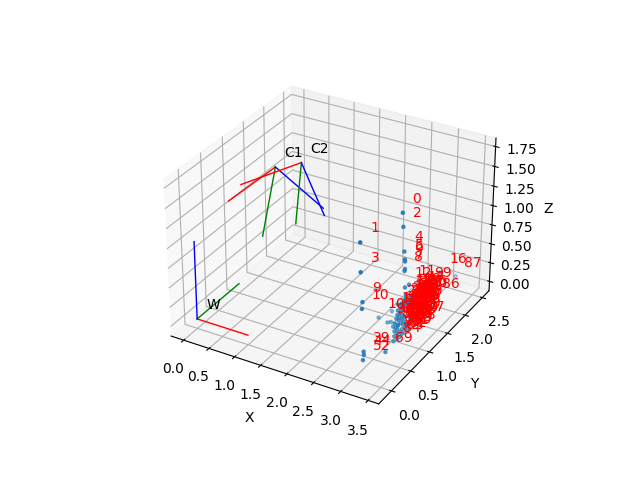

In [5]:
%matplotlib widget
# Plot the triangulated points
fig3D = plt.figure(3)

ax = plt.axes(projection='3d', adjustable='box')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plotData.drawRefSystem(ax, np.eye(4, 4), '-', 'W')
plotData.drawRefSystem(ax, T_w_c1, '-', 'C1')
plotData.drawRefSystem(ax, T_w_c2, '-', 'C2')

ax.scatter(X[0, :], X[1, :], X[2, :], marker='.')
plotData.plotNumbered3DPoints(ax, X, 'r', (0.1, 0.1, 0.1)) # For plotting with numbers (choose one of the both options)
plt.show()

## Fundamental matrix and Structure from Motion

### Epipolar lines visualization

Implement a function for representing an epipolar line in image 2 given a clicked point on image 1. For checking your code you can use the testing fundamental matrix F_21_test.txt provided in the support files of the practice.

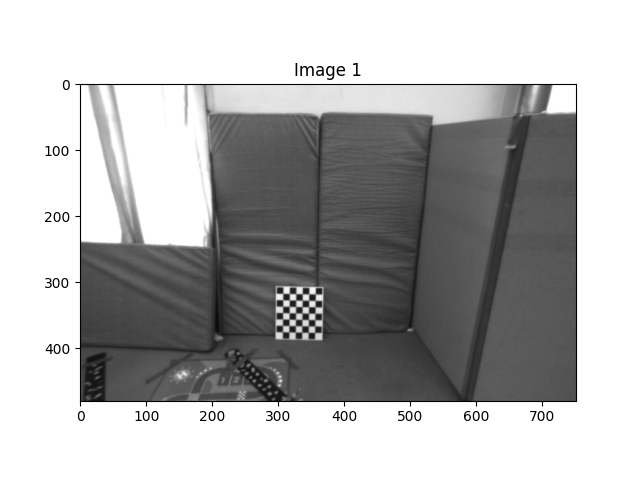

KeyboardInterrupt: 

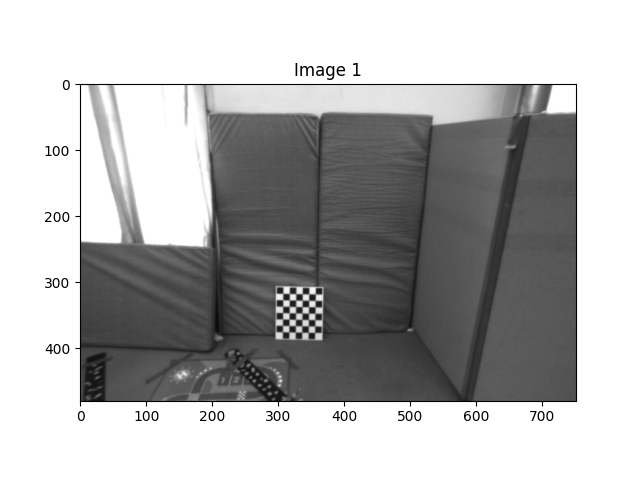

In [11]:
%matplotlib widget
# Implement a function for representing an epipolar line in image 2 given a clicked point on image 1. For checking your code you can use the testing fundamental matrix F_21_test.txt provided in the support files of the practice.
# load the fundamental matrix
F = np.loadtxt('F_21_test.txt')
# show image 1 and wait for a click
plt.close('all')
plt.figure(1)
plt.imshow(img1)
plt.title('Image 1')
plt.draw()
plt.waitforbuttonpress()
point = plt.ginput(1)
# plot the clicked point on image 1 and the epipolar line on image 2
plt.plot(point[0][0], point[0][1], 'rx', markersize=10)
plotData.plotNumberedImagePoints(x2, 'r', (10,0))
plt.figure(2)
plt.imshow(img2)
plt.title('Image 2')
# calculate the epipolar line
epipolar_line = F @ np.append(point[0], 1)
# plot the epipolar line
plt.plot([0, img2.shape[1]], [(-epipolar_line[2] - epipolar_line[0] * 0) / epipolar_line[1], (-epipolar_line[2] - epipolar_line[0] * img2.shape[1]) / epipolar_line[1]], 'g')
plt.draw()
plt.waitforbuttonpress()

### Fundamental matrix definition

In [149]:
# load the poses
T_w_c1 = np.loadtxt('T_w_c1.txt')
T_w_c2 = np.loadtxt('T_w_c2.txt')
# compute the fundamental matrix given the poses
F = np.linalg.inv(T_w_c2) @ T_w_c1
F

array([[ 0.89466952,  0.1454394 , -0.42239272,  0.7369372 ],
       [-0.15320281,  0.98807068,  0.01571646, -0.72566797],
       [ 0.4196393 ,  0.05065066,  0.90627766,  0.65463666],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])